In [1]:
import numpy as np

import torch
import mm3dtestdata as mm3d
import fusecam
from fusecam.geometric import space
from fusecam.geometric import embedplane
from fusecam.geometric import interpolate
from fusecam.manipimg import rotate_tensor_cube

from fusecam.aiutil import train_scripts
from fusecam.aiutil import ensembling

import matplotlib.pyplot as plt
import einops

from torch.utils.data import TensorDataset, DataLoader

from dlsia.core.networks import sms3d
from dlsia.core import helpers
from dlsia.viz_tools import draw_sparse_network


import torch.nn as nn
import torch.optim as optim



First we need to build test data, low res and high res.

In [2]:
MATERIAL = "VEQC" #"VEQI" # "VEQF", "VEQM"
SIGMA_LOW = 1.0 # 3.0
N_PLANES = 4 # 10
SEM_NOISE = 0.00 # 0.1

_TOMO_NOISE = 0.00
_SIGMA_GT  = 0.5
_SEED = 121212

In [3]:
scale = 64
border = 15
radius = 10
sigma_low = SIGMA_LOW
sigma_high = _SIGMA_GT

In [4]:
obj = mm3d.balls_and_eggs(scale=scale, border=border, radius=radius, k0=0.80, seed=_SEED)
_, instance_map_0, class_map_0 = obj.fill()

/tmp/ipykernel_158251/2568210724.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', 3)


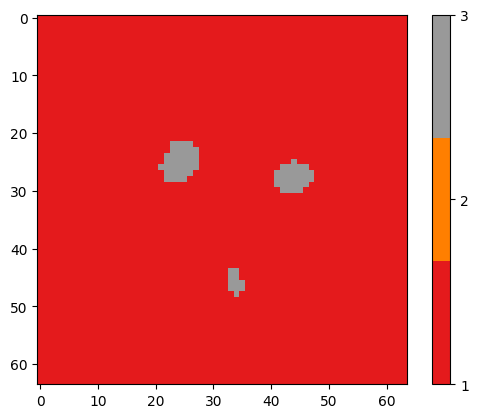

In [5]:
cmap = plt.cm.get_cmap('Set1', 3)
plt.imshow(class_map_0[scale//2,...], cmap=cmap, interpolation='none')
cbar = plt.colorbar(ticks=[0,1,2,3] )#np.arange(np.min(0), np.max(3) + 1))
plt.show()

In [6]:
class_map_low = mm3d.blur_it(class_map_0, sigma=sigma_low)
class_map_high = mm3d.blur_it(class_map_0, sigma=sigma_high)

In [7]:
#if MATERIAL == "VEQI":
#    elems = ["Si", "Fe"]
print(MATERIAL)
low_map, _, _ = mm3d.build_material_maps_XCT_SEM_EDX(class_map_low, MATERIAL)
xct_high_ref, high_map, elements = mm3d.build_material_maps_XCT_SEM_EDX(class_map_high, MATERIAL)
print(elements)

VEQC
['Si', 'Ca', 'Fe', 'Al']


In [8]:
print(high_map.shape, low_map.shape)

(4, 64, 64, 64) (1, 64, 64, 64)


In [9]:
low_map = low_map + mm3d.noise(low_map, _TOMO_NOISE, 0.0)
high_map = high_map + mm3d.noise(high_map, SEM_NOISE, 0.0)

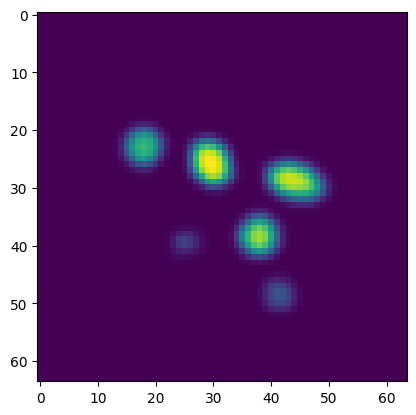

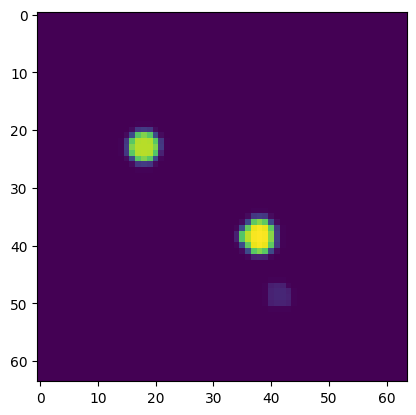

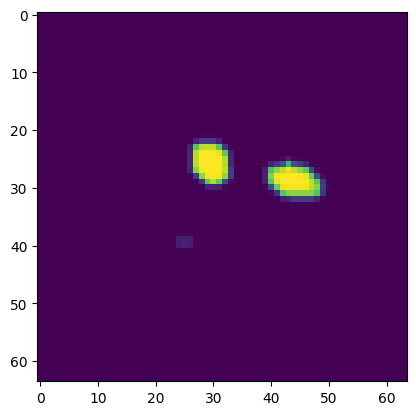

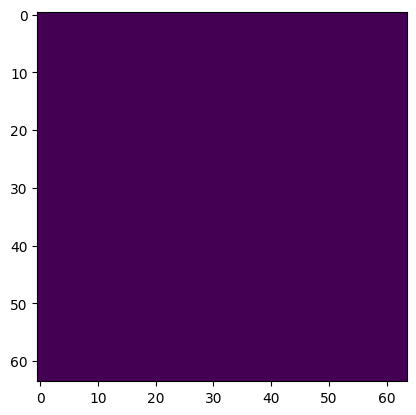

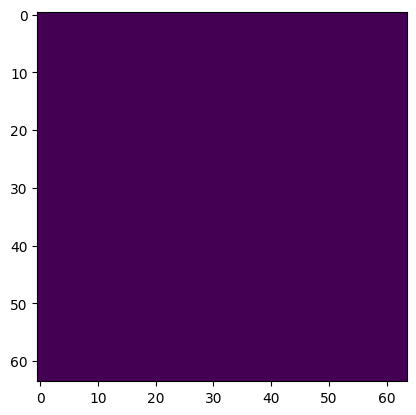

In [10]:
plt.imshow(low_map[0, :,:,scale//2])
plt.show()

plt.imshow(high_map[0, :,:,scale//2])
plt.show()

plt.imshow(high_map[1, :,:,scale//2])
plt.show()

plt.imshow(high_map[2, :,:,scale//2])
plt.show()

plt.imshow(high_map[3, :,:,scale//2])
plt.show()



Now that we have data, I will use have to make the geometric objects

In [11]:
space_object = space.SpatialVolumeMetric(origin=(0,0,0),
                                         step_size=(1,1,1),
                                         orientation = torch.eye(3),
                                         translation = (0,0,0),
                                        )
plane_object = space.SpatialPlaneMetric(origin=(0,0),
                                         step_size=(1,1),
                                         orientation = torch.eye(2),
                                         translation = (0,0))

Now we have the two geometric objects, I want define a plane and get stuff going

In [12]:
u = torch.linspace(0,scale-1,scale)
U,V = torch.meshgrid(u,u, indexing='ij')
UV = torch.concat([U.flatten().reshape(1,-1), V.flatten().reshape(1,-1)]).T

x = torch.linspace(0,scale-1,scale)
X,Y,Z = torch.meshgrid(x,x,x, indexing="ij")
XYZ = torch.concat([X.flatten().reshape(1,-1), Y.flatten().reshape(1,-1), Z.flatten().reshape(1,-1),]).T
print(UV.shape, XYZ.shape)

torch.Size([4096, 2]) torch.Size([262144, 3])


In [13]:
normal = np.array([0.2, 0.2, 1.0])
locations = np.linspace(scale//2-scale//3, scale//2+scale//3,N_PLANES+2)[1:-1]
print("plane locations", locations)
flat_high_map = einops.rearrange( torch.Tensor(high_map), "C X Y Z -> (X Y Z) C ")
flat_low_map = einops.rearrange( torch.Tensor(low_map), "C X Y Z -> (X Y Z) C ")


plane locations [19.4 27.8 36.2 44.6]


Below we use interpolation to construc the cut plane with SEM-EDX data and the corresponding XCT data.
The same interpolation tables are used.

We don't need the interpolation tables, as we will work directly against the images in this case.

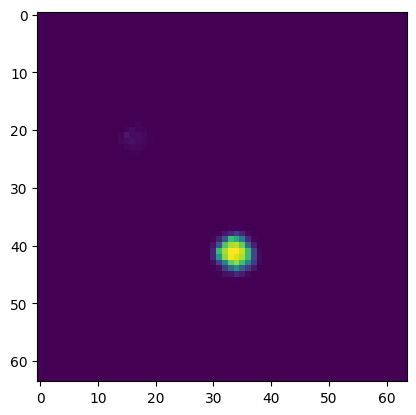

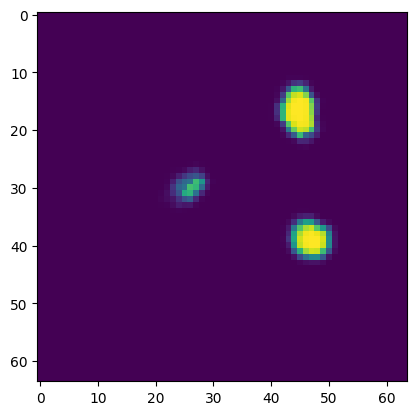

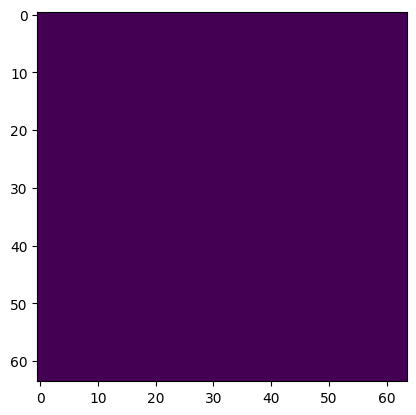

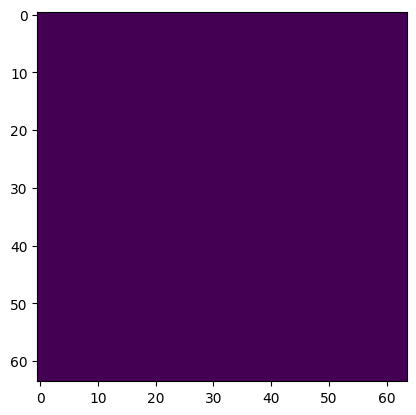

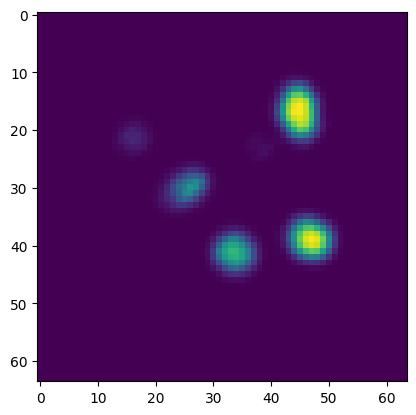

--------------------------


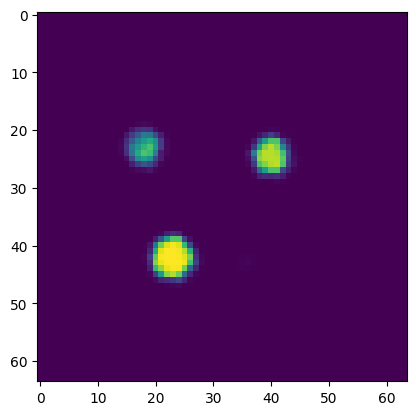

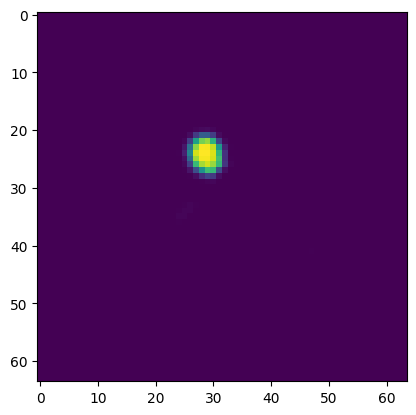

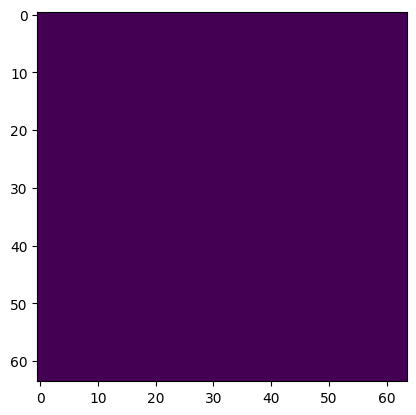

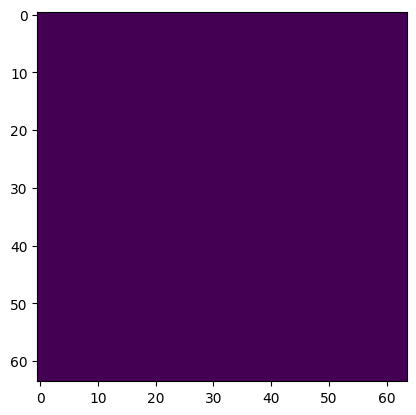

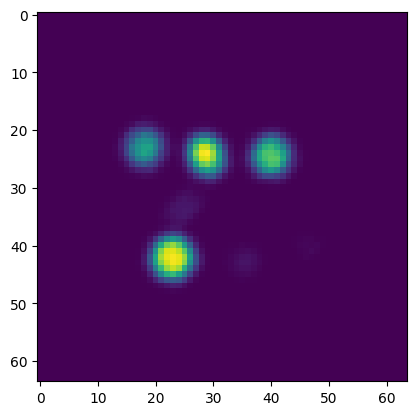

--------------------------


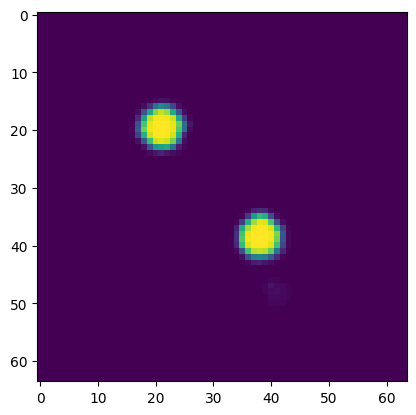

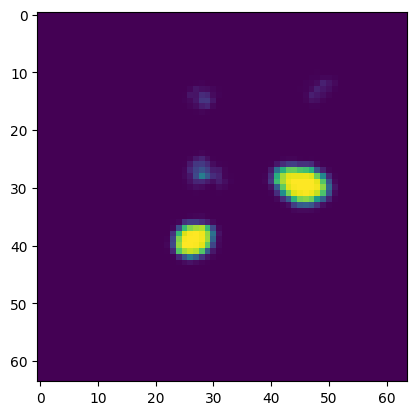

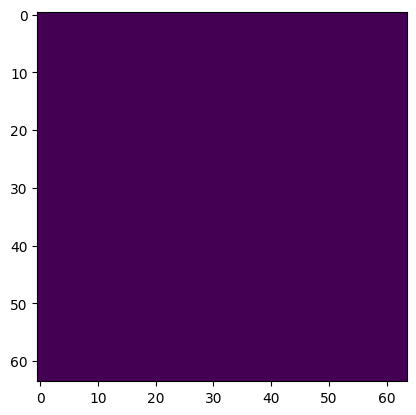

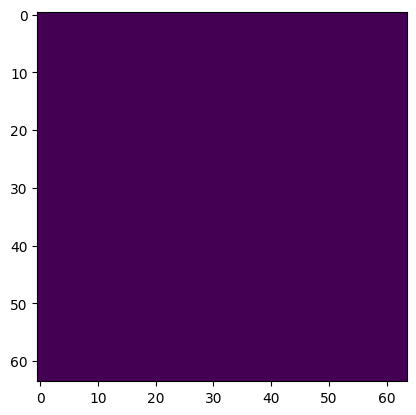

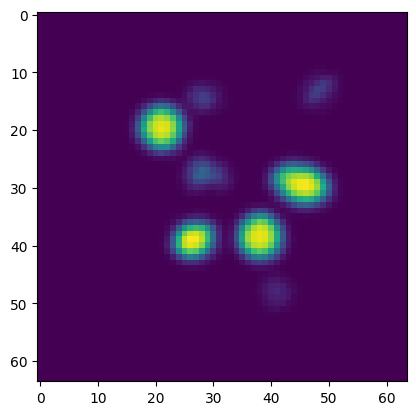

--------------------------


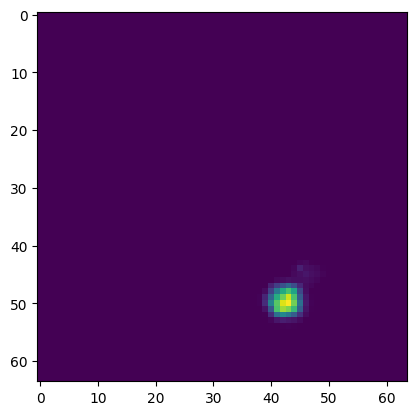

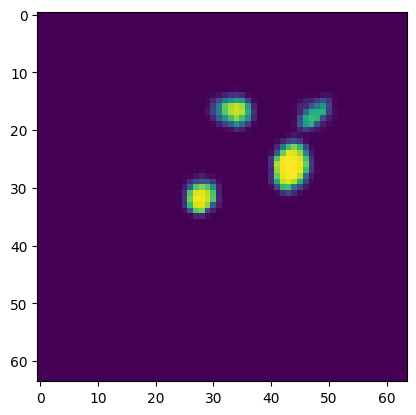

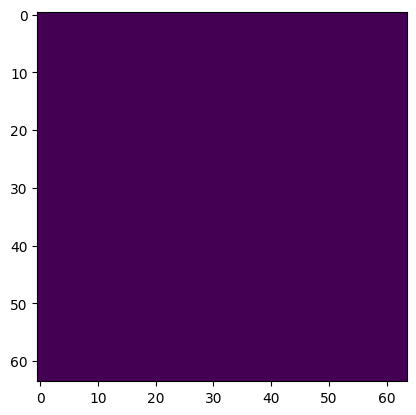

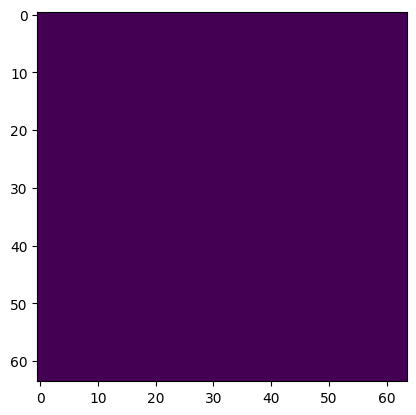

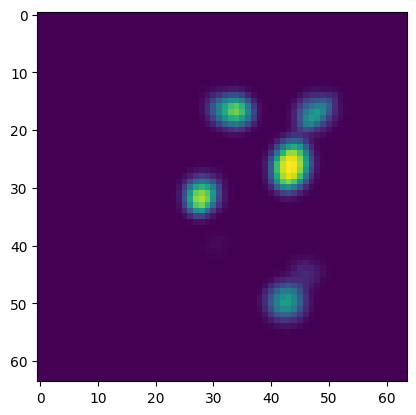

--------------------------


In [14]:
all_indices = []
all_weights = []
all_sem = []
all_xct = []
all_ref_xct = []

for loc in locations:
    normal = normal
    aligner =  embedplane.Plane3DAligner(
        normal=normal, #+delta,
        point_on_plane=[scale//2, scale//2, loc]) 
    point_on_plane_2D = (scale//2,scale//2)
    aligned_points = aligner.align_points_to_3d(UV, point_on_plane_2D, rotation_angle=0)
    
    indices, near_dist = interpolate.find_nearest(XYZ, aligned_points, 121)
    weights = interpolate.compute_weights(near_dist, power=1.0, cutoff=2.0)    
    
    sem = interpolate.inverse_distance_weighting_with_weights_MC(flat_high_map,indices,weights)   
    sem = einops.rearrange(sem, "(X Y) C-> C X Y", X=scale,Y=scale)
    all_sem.append(sem)
    
    for i in range(sem.shape[0]):
        plt.imshow(sem[i])
        plt.show()
        
    
    xct = interpolate.inverse_distance_weighting_with_weights_MC(flat_low_map,indices,weights)   
    xct = einops.rearrange(xct, "(X Y) C-> C X Y", X=scale,Y=scale)
    all_xct.append(xct)
   
    plt.imshow(xct[0])
    plt.show()
    
    ref_xct = interpolate.inverse_distance_weighting_with_weights_MC(flat_low_map,indices,weights)   
    ref_xct = einops.rearrange(xct, "(X Y) C-> C X Y", X=scale,Y=scale)
    all_xct.append(xct)
   
    plt.imshow(xct[0])
    plt.show()
    
    
    print("--------------------------")
    

    
    

In [15]:
my_xct_maps = torch.concat([torch.Tensor(np.stack(all_xct))])
my_sem_maps = torch.concat([torch.Tensor(np.stack(all_sem))])

In [ ]:
print(my_xct_maps.shape, my_sem_maps.shape)

In [ ]:
my_data = TensorDataset(my_sem_maps, my_xct_maps)
data_loader = DataLoader(my_data, batch_size=1)

In [ ]:
from fusecam.models.sem_to_xct import SemXctTransformer

In [ ]:
import torch
import torch.nn as nn

class TVLoss(nn.Module):
    def __init__(self):
        super(TVLoss, self).__init__()
    
    def forward(self, img):
        # Compute the Total Variation Loss
        batch_size, _, height, width = img.size()
        tv_h = torch.abs(img[:,:,1:,:]-img[:,:,:height-1,:]).sum()
        tv_w = torch.abs(img[:,:,:,1:]-img[:,:,:,:width-1]).sum()
        return (tv_h + tv_w) / batch_size


In [ ]:
net = SemXctTransformer(4,[4], 2.00, dropout_rate=0.0)

In [ ]:
loss_function = nn.MSELoss()
smooth_loss = TVLoss()

optimizer = optim.Adam(net.parameters(), lr=0.01)
train_scripts.train_slice_on_slice(net,
                                   loss_function,
                                   smooth_loss,
                                   optimizer,
                                   data_loader,
                                   100,
                                   0.00000,
                                   device='cuda:0')
print()
print()

In [ ]:
with torch.no_grad():
    plt.imshow(my_xct_maps[1,0])
    plt.colorbar()
    plt.show()
    sem, total = net.cpu()(my_sem_maps)
    sem = sem.numpy()
    total = total.numpy()
    plt.imshow(total[1,0])    
    plt.colorbar()
    plt.show()
    
    plt.imshow(total[1,0] - my_xct_maps[1,0].numpy())
    plt.colorbar()
    plt.show()
    
    
    
    plt.imshow(sem[1,0])
    plt.colorbar()
    plt.show()
    
    print(net.blur_object.sigma)
    
 
    #part1 = net.sem_tomo_projector()